# Limber checks using CLASS

## $C_{\ell}^{\delta\kappa}$

In [8]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib

# esthetic definitions for the plots
font = {'size'   : 16, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='small'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [ ]:
#####################################################
#
# Cosmological parameters and other CLASS parameters
#
#####################################################
from classy import Class
import numpy as np

from scipy.interpolate import interp1d

omch2 = 0.12038
ombh2 = 0.022032
h = 0.67556 #H0/100
cspeed = 299792.458 # km/s
A_s = 2.215e-9
n_s = 0.9619
tau_reion = 0.079
neff=3.046

ellmax = 2000
nell   = 400
zmax = 2.0


mu_z1    = 0.8
sigma_z1 = 0.1
# redshift bin 2
mu_z2    = 1.2
sigma_z2 = 0.1
#
ns = 4.0 # number of sigma in integration
nz = 400 #number of steps to use for the radial/redshift integration
#
def norm_gaussian(x,mu,sigma):
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2)

# Define your cosmology (what is not specified will be set to CLASS default parameters)
pars = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 4000,
    'lensing': 'yes',
    'non linear': 'halofit',
    'omega_b' : ombh2,
    'omega_cdm' : omch2,
    'h' : h,
    'ln10^{10}A_s' : np.log(10**10 *A_s),
    'n_s' : n_s,
    'tau_reio' : tau_reion,
    'N_eff': neff,
    'YHe' : 0.24,
    'N_ncdm' : 0,
    'halofit_k_per_decade' : 3000.,
    'l_switch_limber' : 40.,
    'accurate_lensing':1,
    'num_mu_minus_lmax' : 1000.,
    'delta_l_max' : 1000.,
    'z_max_pk':zmax}

k_max = 1;

#Initialize the cosmology andcompute everything
cosmo = Class()
cosmo.set(pars)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
z = 0.8

#Call these for linear matter power spectra
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])



background  = cosmo.get_background()
# comivng distance is in units Mpc
comoving_dist = background['comov. dist.']
ztab = background['z']

# interpolation function of comoving distance
comoving_dist_intp = interp1d(ztab,comoving_dist,kind='cubic')

Hubble = background['H [1/Mpc]']
Hubble_intp = interp1d(ztab,Hubble,kind='cubic')

growth_factor = background['gr.fac. D']
growth_factor_intp = interp1d(ztab,growth_factor,kind='cubic')



z1  = np.linspace(mu_z1-ns*sigma_z1,mu_z1+ns*sigma_z1,num=nz,endpoint=False) # should use better integrator formula
z2  = np.linspace(mu_z2-ns*sigma_z2,mu_z2+ns*sigma_z2,num=nz,endpoint=False)
dz1 = z1[1]-z1[0]
dz2 = z2[1]-z2[0]


ellarr_class = np.linspace(2,ellmax,nell)
resarr_class = np.zeros(np.size(ellarr_class))

for il, ell in enumerate(ellarr_class):
    res_c = 0.0
    for iz in z1:
        chi_iz = comoving_dist_intp(iz) # returns comoving radial distance chi in Mpc
        kz     = (0.5+ell)/chi_iz
        Pkz    = cosmo.pk_lin(kz, iz)
        W_iz   = norm_gaussian(iz,mu_z1,sigma_z1)
        for jz in z2:
            chi_jz = comoving_dist_intp(jz) # returns comoving radial distance chi in Mpc
            W_jz   = norm_gaussian(jz,mu_z2,sigma_z2)
            res_c    = res_c + W_iz*(1.0+iz)*Pkz*W_jz*(chi_jz-chi_iz)/(chi_jz*chi_iz)
    res_c = res_c*(1.0+ell)*ell/(0.5+ell)**2
    res_c = res_c*1.5*(omch2+ombh2)*100.0**2/cspeed**2 # units 1/Mpc^2
    resarr_class[il]=res_c*dz1*dz2
    print(ell,res_c)


# Save results to output file
np.savez_compressed('cl_cross_limber_usingCLASSfunctions2.npz',l_limber=ellarr_class,cl_limber=resarr_class)


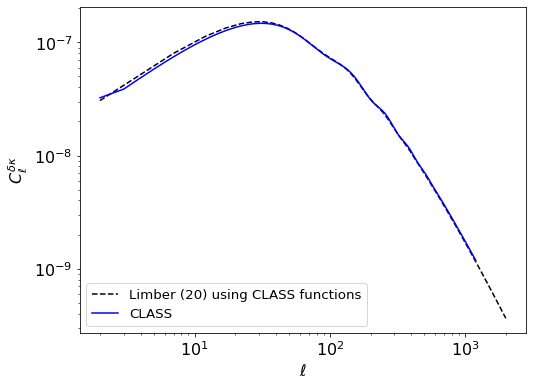

In [16]:


data_limber_class = np.load('cl_cross_limber_usingCLASSfunctions2.npz')

l_limber_class  = data_limber_class['l_limber']
cl_limber_class = data_limber_class['cl_limber']



plt.xscale('log')
plt.yscale('log')

plt.plot(l_limber_class,cl_limber_class,color='k',label='Limber (20) using CLASS functions', linestyle='dashed')
plt.plot(l, Cl_deltakappa_Class, label = 'CLASS',color='b')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell^{\delta\kappa}$')
plt.legend()

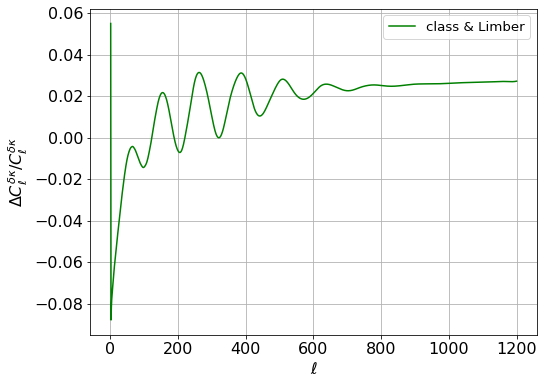

In [18]:
from scipy.interpolate import interp1d


cl_limberclass_f = interp1d(l_limber_class,cl_limber_class,kind='cubic')
cl_limberclass_intp = cl_limberclass_f(l)


relative_difference_class = (Cl_deltakappa_Class - cl_limberclass_intp)/Cl_deltakappa_Class

plt.plot(l, relative_difference_class, color='g', label = 'class & Limber')


plt.grid()
plt.xlabel('$\ell$')
plt.ylabel('$\Delta C_\ell^{\delta\kappa}/C_\ell^{\delta\kappa}$')
plt.legend()
plt.show()